In [1]:
import numpy as np
import pandas as pd
from typing import Final
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
plt.rcParams['figure.figsize'] = [20, 10]

In [3]:
def get_gsp_data() -> pd.DataFrame:
    dfs = []
    filenames = ["gsp0.csv", "gsp1-50.csv", "gsp51-100.csv", "gsp101-150.csv", "gsp201-250.csv", "gsp251-300.csv", "gsp301-350.csv"]
    for start_gsp_id in range(151, 200, 10):
        filenames.append(f"gsp{start_gsp_id}-{start_gsp_id+9}.csv")

    for filename in filenames:
        full_filename = f"~/data/PV/PV_Live/from_OCF_production_database/{filename}"
        print(full_filename, flush=True)
        df = pd.read_csv(
            full_filename,
            header=0,
            names=["created_utc", "regime", "solar_generation_kw", "datetime_utc", "gsp_id", "gsp_name", "region_name", "installed_capacity_mw"],
            parse_dates=["datetime_utc"],
            index_col="datetime_utc",
            usecols=["datetime_utc", "regime", "solar_generation_kw", "gsp_id"],
            dtype={"regime": "category", "gsp_id": np.int16, "solar_generation_kw": np.float32},
            )
        df.solar_generation_kw /= 1E6
        df.rename({"solar_generation_kw": "solar_generation_gw"}, axis=1, inplace=True)
        dfs.append(df)
    return pd.concat(dfs)

df = get_gsp_data()

~/data/PV/PV_Live/from_OCF_production_database/gsp0.csv
~/data/PV/PV_Live/from_OCF_production_database/gsp1-50.csv
~/data/PV/PV_Live/from_OCF_production_database/gsp51-100.csv
~/data/PV/PV_Live/from_OCF_production_database/gsp101-150.csv
~/data/PV/PV_Live/from_OCF_production_database/gsp201-250.csv
~/data/PV/PV_Live/from_OCF_production_database/gsp251-300.csv
~/data/PV/PV_Live/from_OCF_production_database/gsp301-350.csv
~/data/PV/PV_Live/from_OCF_production_database/gsp151-160.csv
~/data/PV/PV_Live/from_OCF_production_database/gsp161-170.csv
~/data/PV/PV_Live/from_OCF_production_database/gsp171-180.csv
~/data/PV/PV_Live/from_OCF_production_database/gsp181-190.csv
~/data/PV/PV_Live/from_OCF_production_database/gsp191-200.csv


In [4]:
national_intra_csv = pd.read_csv(
    "~/data/PV/PV_Live/from_OCF_production_database/intra-pv2.csv",
    parse_dates=["datetime_utc"],
    index_col="datetime_utc",
    usecols=["datetime_utc", "solar_generation_kw"],
    dtype={"regime": "category", "gsp_id": np.int16, "solar_generation_kw": np.float32},
    ).squeeze() / 1E6

national_intra_csv.name = "solar_generation_gw"
national_intra_csv

datetime_utc
2022-06-14 08:00:00    3.67000
2022-06-14 08:30:00    4.39000
2022-06-14 09:00:00    5.02000
2022-06-14 09:30:00    5.42000
2022-06-14 10:00:00    5.76000
                        ...   
2023-04-25 08:00:00    3.80843
2023-04-25 08:30:00    4.68315
2023-04-25 09:00:00    5.51897
2023-04-25 09:30:00    6.25048
2023-04-25 10:00:00    6.77540
Name: solar_generation_gw, Length: 15484, dtype: float32

In [5]:
intraday_mask = df.regime == "in-day"
intraday = df.loc[intraday_mask]
updated = df.loc[~intraday_mask]

def get_national(df: pd.DataFrame) -> pd.Series:
    return df.loc[df.gsp_id == 0].solar_generation_gw

def get_sum_of_gsps(df: pd.DataFrame) -> pd.Series:
    return df.loc[df.gsp_id != 0].groupby("datetime_utc").solar_generation_gw.sum()

intraday_national = get_national(intraday)
updated_national = get_national(updated)
intraday_sum_of_gsps = get_sum_of_gsps(intraday)
updated_sum_of_gsps = get_sum_of_gsps(updated)


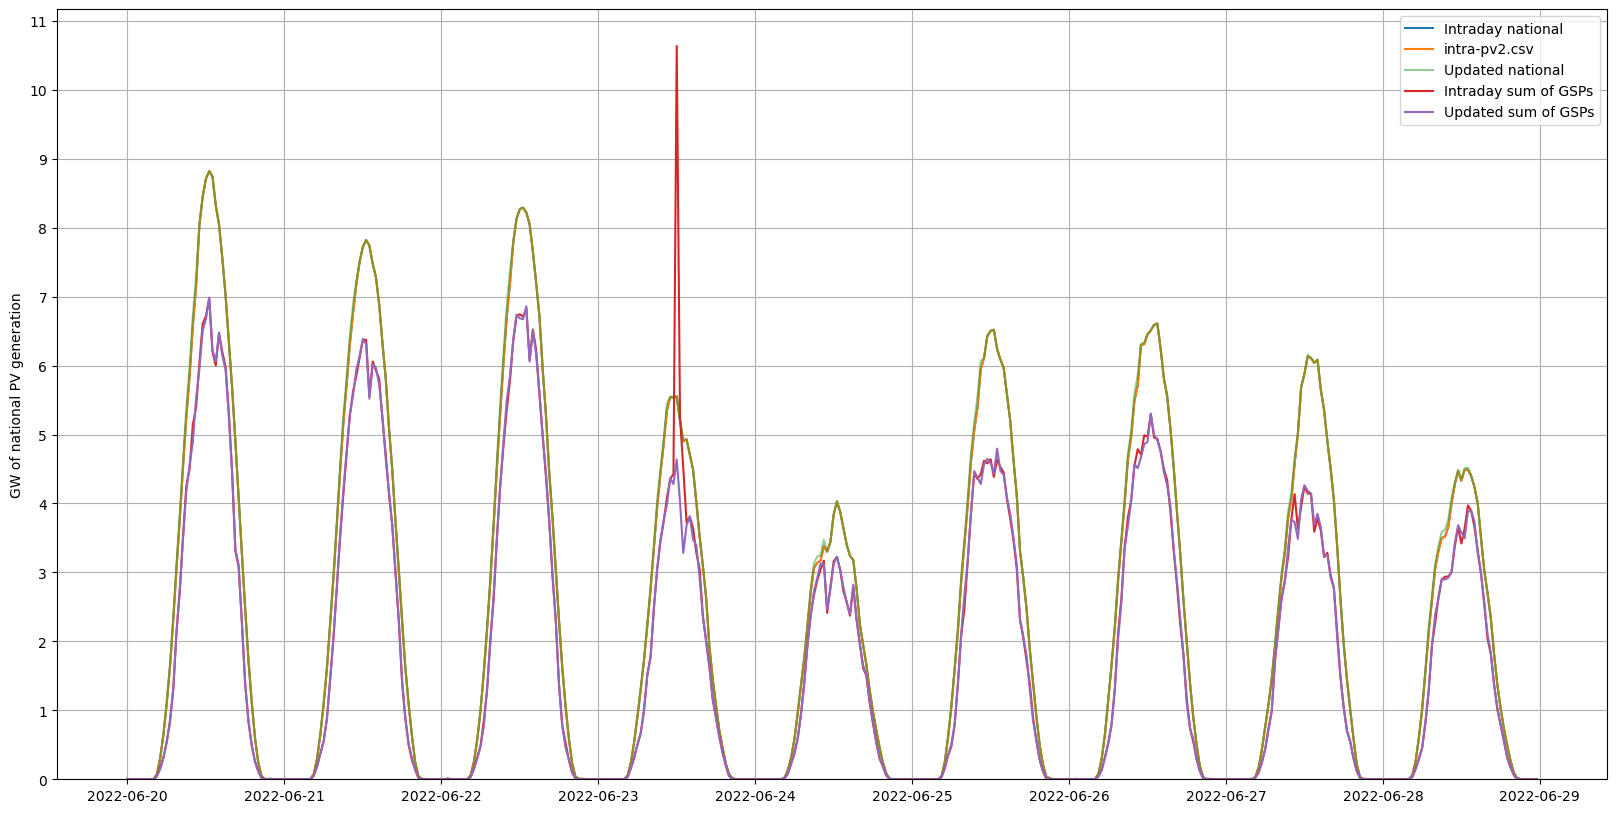

In [8]:
START_DATE: Final[str] = "2022-06-20"
END_DATE: Final[str] = "2022-06-28"

fig, ax = plt.subplots()

ax.plot(
    intraday_national[START_DATE:END_DATE],
    label="Intraday national",
)

ax.plot(
    national_intra_csv[START_DATE:END_DATE],
    label="intra-pv2.csv",
)

ax.plot(
    updated_national[START_DATE:END_DATE],
    label="Updated national",
    alpha=0.5,
)

ax.plot(
    intraday_sum_of_gsps[START_DATE:END_DATE],
    label="Intraday sum of GSPs",
)

ax.plot(
    updated_sum_of_gsps[START_DATE:END_DATE],
    label="Updated sum of GSPs",
)

ax.legend()
ax.grid()
ax.set_ylim([0, ax.get_ylim()[1]])
ax.set_ylabel("GW of national PV generation")
ax.yaxis.set_major_locator(mticker.MultipleLocator(1))

In [28]:
intraday

,regime,solar_generation_gw,gsp_id
datetime_utc,,,
2022-06-14 08:00:00,in-day,3.670000,0
2022-06-14 08:30:00,in-day,4.390000,0
2022-06-14 09:00:00,in-day,5.020000,0
2022-06-14 09:30:00,in-day,5.420000,0
2022-06-14 10:00:00,in-day,5.760000,0
...,...,...,...
2023-04-27 13:30:00,in-day,0.000474,200
2023-04-27 14:00:00,in-day,0.000531,200
2023-04-27 14:30:00,in-day,0.000416,200


In [29]:
updated

,regime,solar_generation_gw,gsp_id
datetime_utc,,,
2022-06-14 00:00:00,day-after,0.0,0
2022-06-14 00:30:00,day-after,0.0,0
2022-06-14 01:00:00,day-after,0.0,0
2022-06-14 01:30:00,day-after,0.0,0
2022-06-14 02:00:00,day-after,0.0,0
...,...,...,...
2023-04-26 22:00:00,day-after,0.0,200
2023-04-26 22:30:00,day-after,0.0,200
2023-04-26 23:00:00,day-after,0.0,200
